Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import joblib
import sklearn

from sklearn.metrics import accuracy_score ,recall_score , precision_score , classification_report ,  f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler,FunctionTransformer,OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
import numpy as np, pandas as pd, matplotlib, seaborn, sklearn, imblearn, xgboost, plotly, joblib

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("scikit-learn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)
print("xgboost:", xgboost.__version__)
print("plotly:", plotly.__version__)
print("joblib:", joblib.__version__)


numpy: 2.3.1
pandas: 2.3.0
matplotlib: 3.10.0
seaborn: 0.13.2
scikit-learn: 1.6.1
imblearn: 0.13.0
xgboost: 3.0.4
plotly: 6.2.0
joblib: 1.4.2


Load Data


In [3]:
file_path ='./liver_cirrhosis.csv'
def load_data(file_path):
    return pd.read_csv(file_path)

df =load_data(file_path)
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [4]:
data=df.copy()

# EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [6]:
pd.DataFrame(data.isna().sum()).T.style.background_gradient(cmap='rainbow')

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
data.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,1887.117040,18495.877080,3.402644,372.331471,3.486578,100.184663,1995.675597,123.166345,123.822548,256.007337,10.734549,2.00116
std,1091.690918,3737.596616,4.707491,193.668452,0.380488,73.184840,1798.885660,47.747616,52.786350,98.679006,0.904436,0.81387
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.00000
25%,1080.000000,15694.000000,0.800000,275.000000,3.290000,52.000000,1032.000000,92.000000,92.000000,189.000000,10.000000,1.00000
50%,1680.000000,18499.000000,1.300000,369.510563,3.510000,97.648387,1828.000000,122.556346,124.702128,251.000000,10.600000,2.00000
75%,2576.000000,20955.000000,3.400000,369.510563,3.750000,107.000000,1982.655769,134.850000,127.000000,311.000000,11.100000,3.00000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,3.00000


In [8]:
for  x in data :print(x,df[x].unique())

N_Days [2221 1230 4184 2090 2105 4427 1418   51 2504 1012 1149 1037 1234  334
  733 1581 1443 3823 3170 1735 1558 1067 1666  191 1874 1690  460 2176
 3839  727 1092  943 1347 1368 1170 2286 2050 2224 2022 3992 1434 2338
 2995  694  264 2503 1168 2365 3707 2475 2540  681 2171 1455 1769 3445
 1077 2267 2081 1908  799 2111 1419 2255 2576 2202  617 3099 1568 1525
  839 3030 4509 2609 2442 3492 2195  976 2855 1504  348 1301  989 2644
 2797 1702 1320 2834 1103  489 1899 1945 1297  994  352 2527  549  939
 2698 1342 1831  625 3021   77  611 2635 3086 1191 1462 1783 3527 2721
 1725 1343 2103 3820 1785 1656  597 1375 1560 3913 3850 4556 2583 2556
 3255  859  837  974 2071 2332 1119 1615  559  326  193 1349  904 1293
  533  708 2272  691 3584 2990 2976  130 3282 2288 1653 1481  737 1150
 1616 1433  877 2555  732 2297 2468 1536  703 2844  797 1978 1129 2580
 1141 1072 1095 1639 1882 4523 2944 4467 2563 1356 1236 1223 2386 2598
 2769 1786  304 4039 1592  980 2863 4062 2713  853 2452 3336 4795 2666

In [9]:
data.duplicated().sum()

np.int64(15361)

In [10]:
data = data.drop_duplicates()


In [11]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

In [12]:
target = 'Stage'

cont_cols = data.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = data.select_dtypes(object).columns

len(cont_cols), len(obj_cols)

(11, 7)

# Data Visualization 

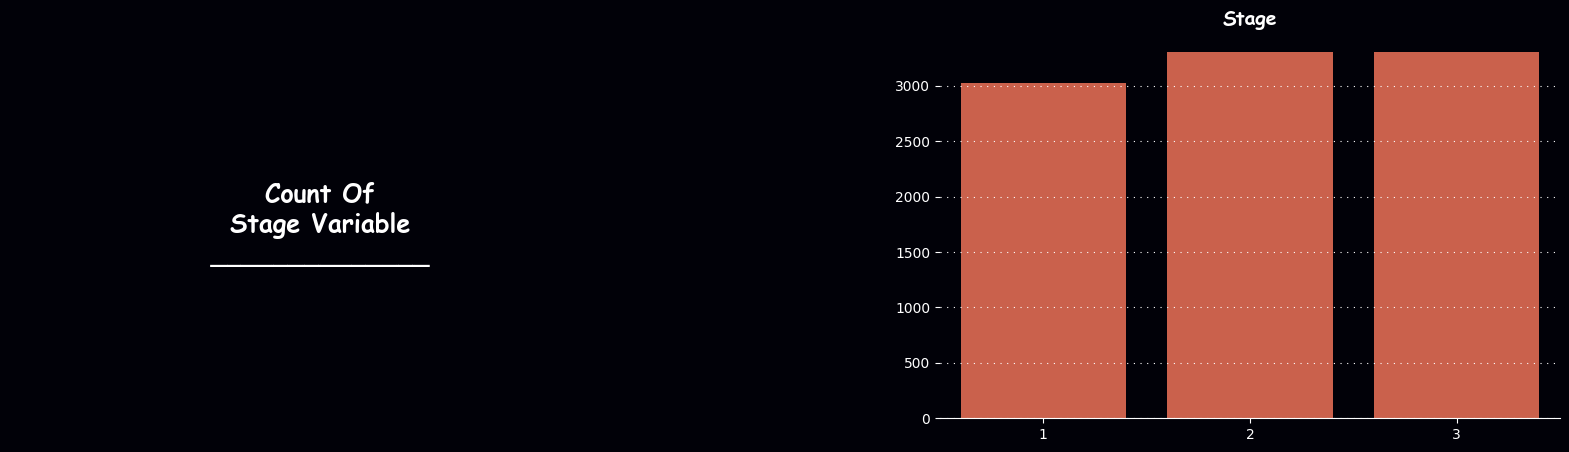

In [13]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\nStage Variable\n______________')

sns.countplot(x=data[target], ax = axes[1], color=palette[0])
cb(axes[1])

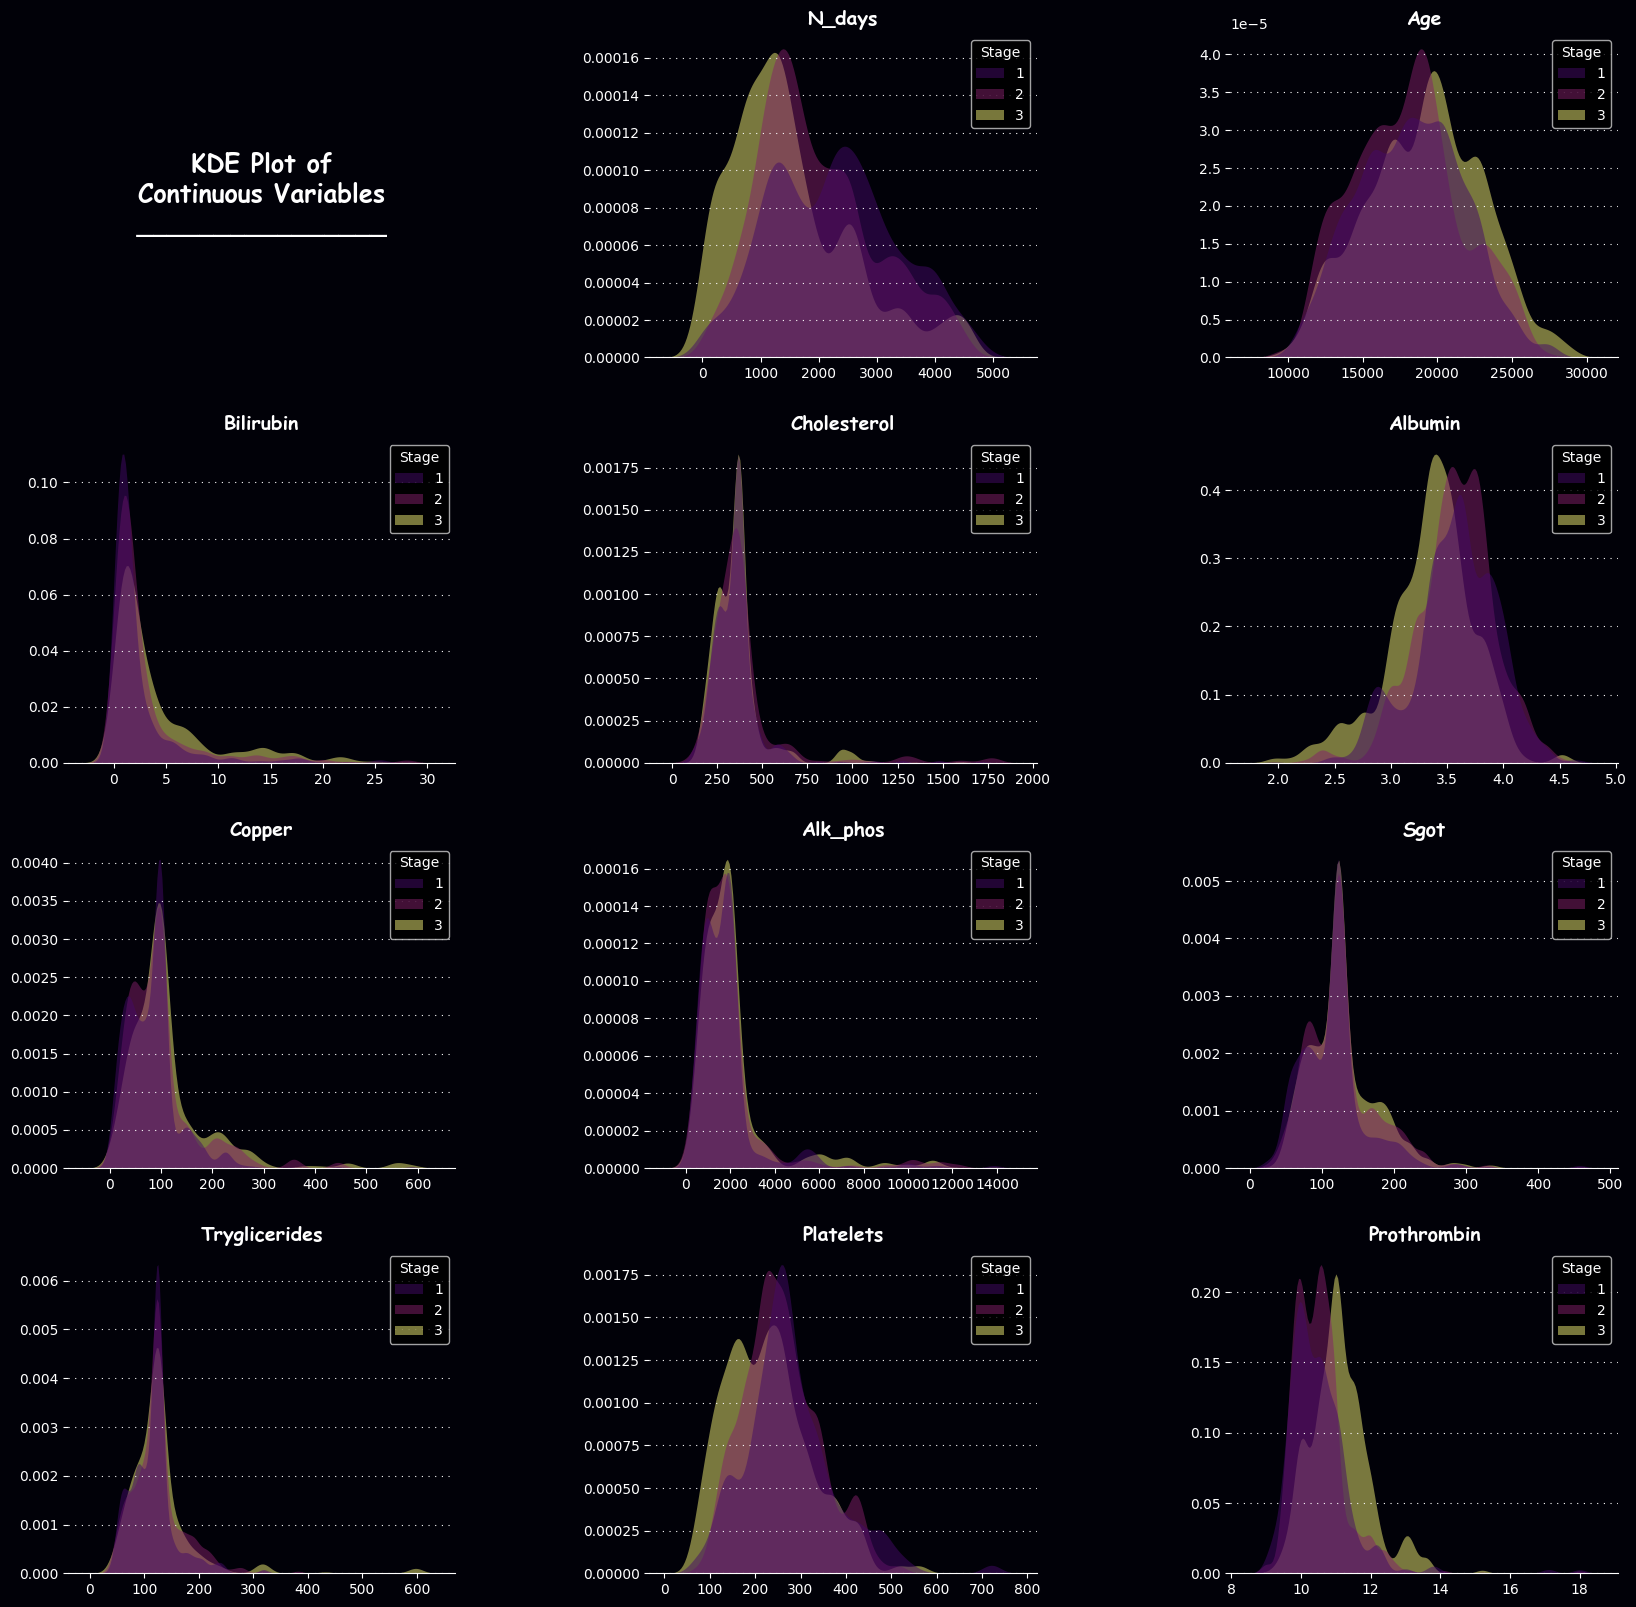

In [14]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=data, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
    cb(ax)

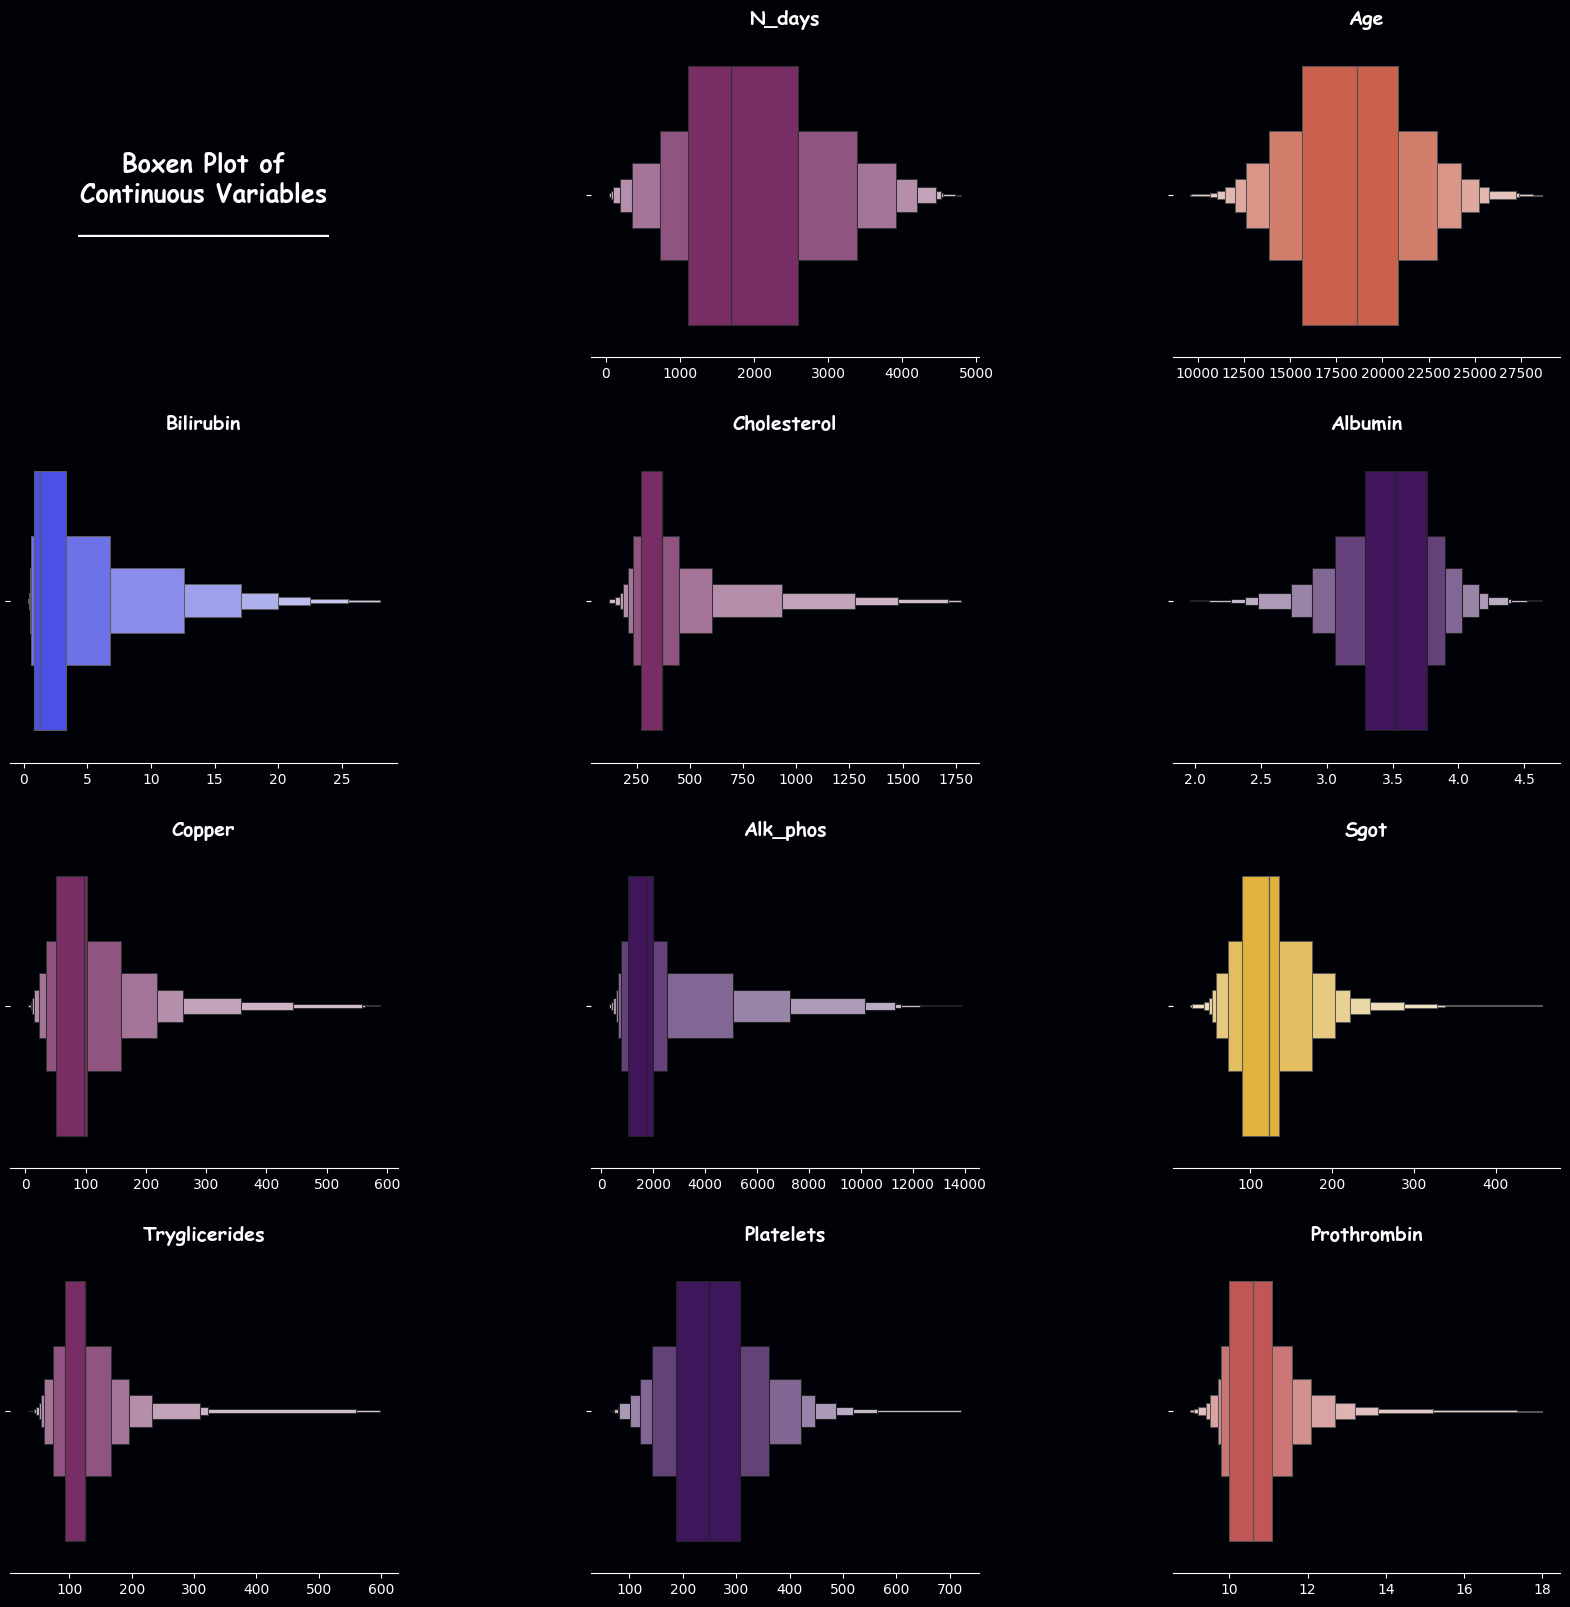

In [15]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=data, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_1604\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_1604\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_1604\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
C:\Users\Hany Mostafa\AppData\Local\Temp\ipykernel_1604\1955764594.py:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce 

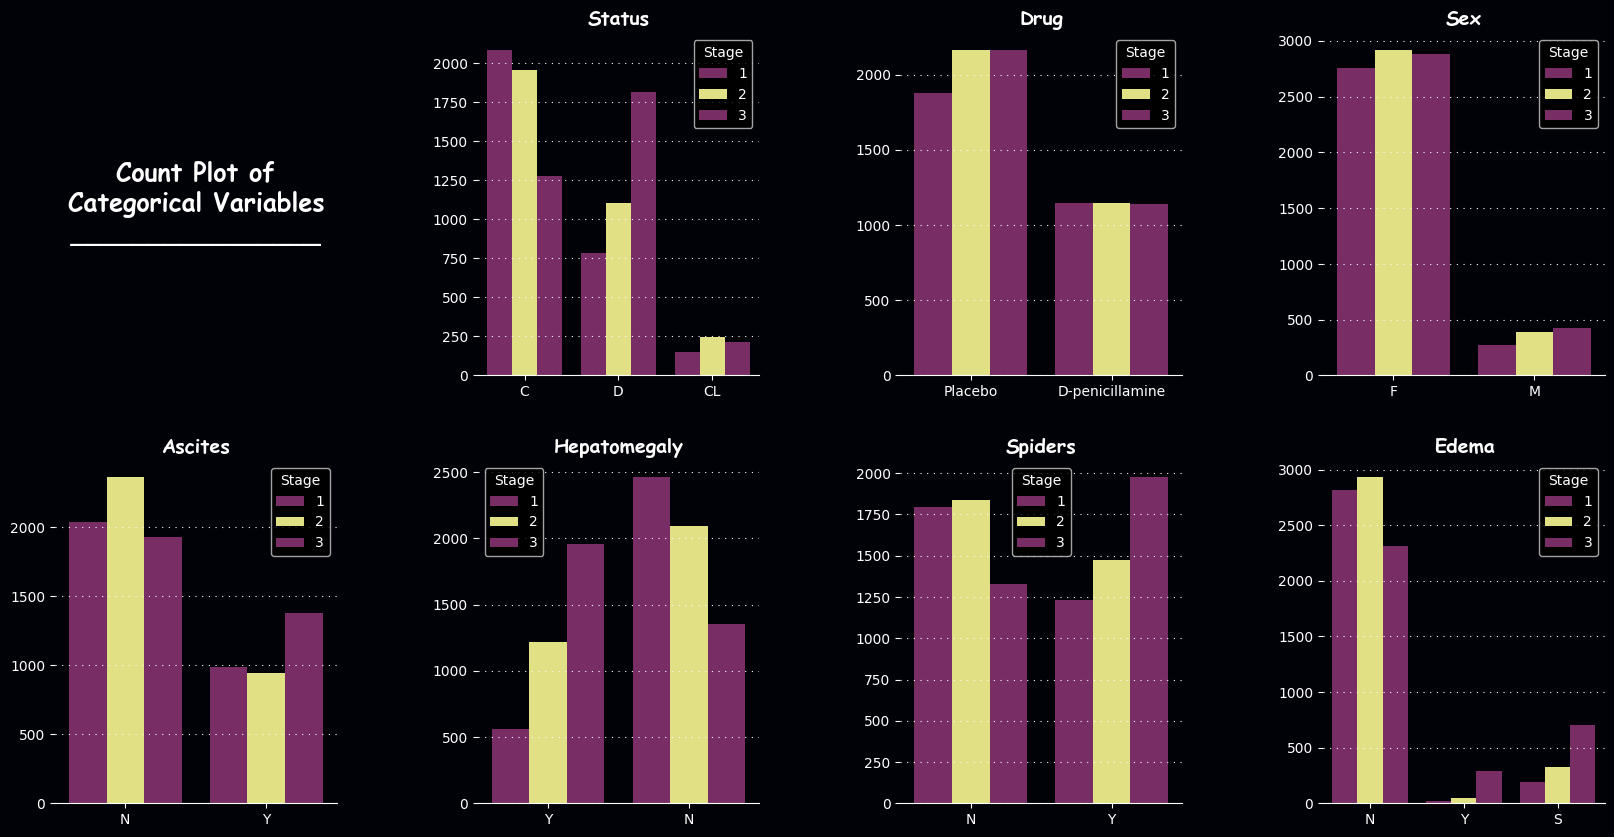

In [16]:
axes, palette, cb = mPlotter(2, 4, (20, 10), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

for col, ax in zip(obj_cols, axes[1:]):
    sns.countplot(data=data, x=col, ax=ax, hue=target, palette=palette[5:7])
    cb(ax)

In [17]:
# data.drop(['Sex','Drug','Spiders','Ascites','Status','Edema'],axis=1,inplace=True) 

In [18]:
target = 'Stage'

cont_cols = data.select_dtypes('number').columns


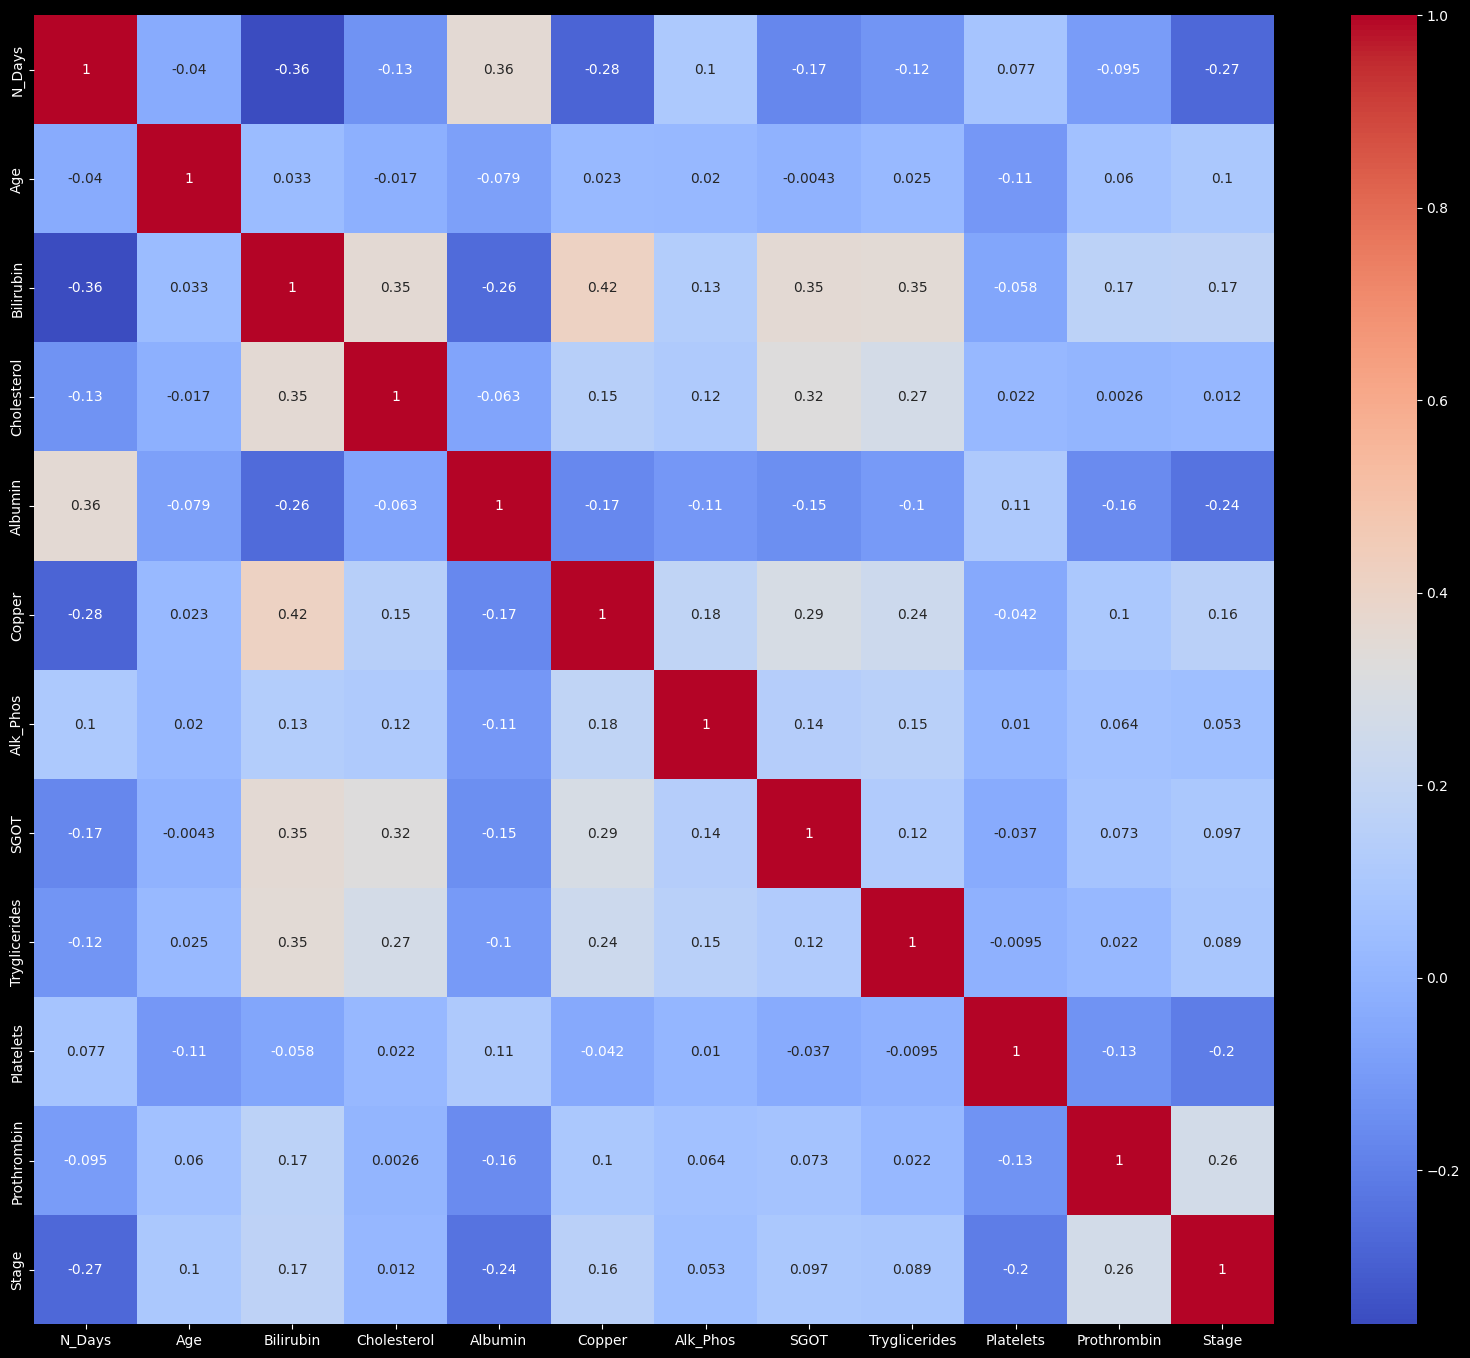

In [19]:
target = 'Stage'

cont_cols = data.select_dtypes('number').columns

corr_matrix =data[cont_cols].corr()
plt.figure(figsize=(20,17))
sns.heatmap(corr_matrix,annot=True,cmap= 'coolwarm')
plt.show()


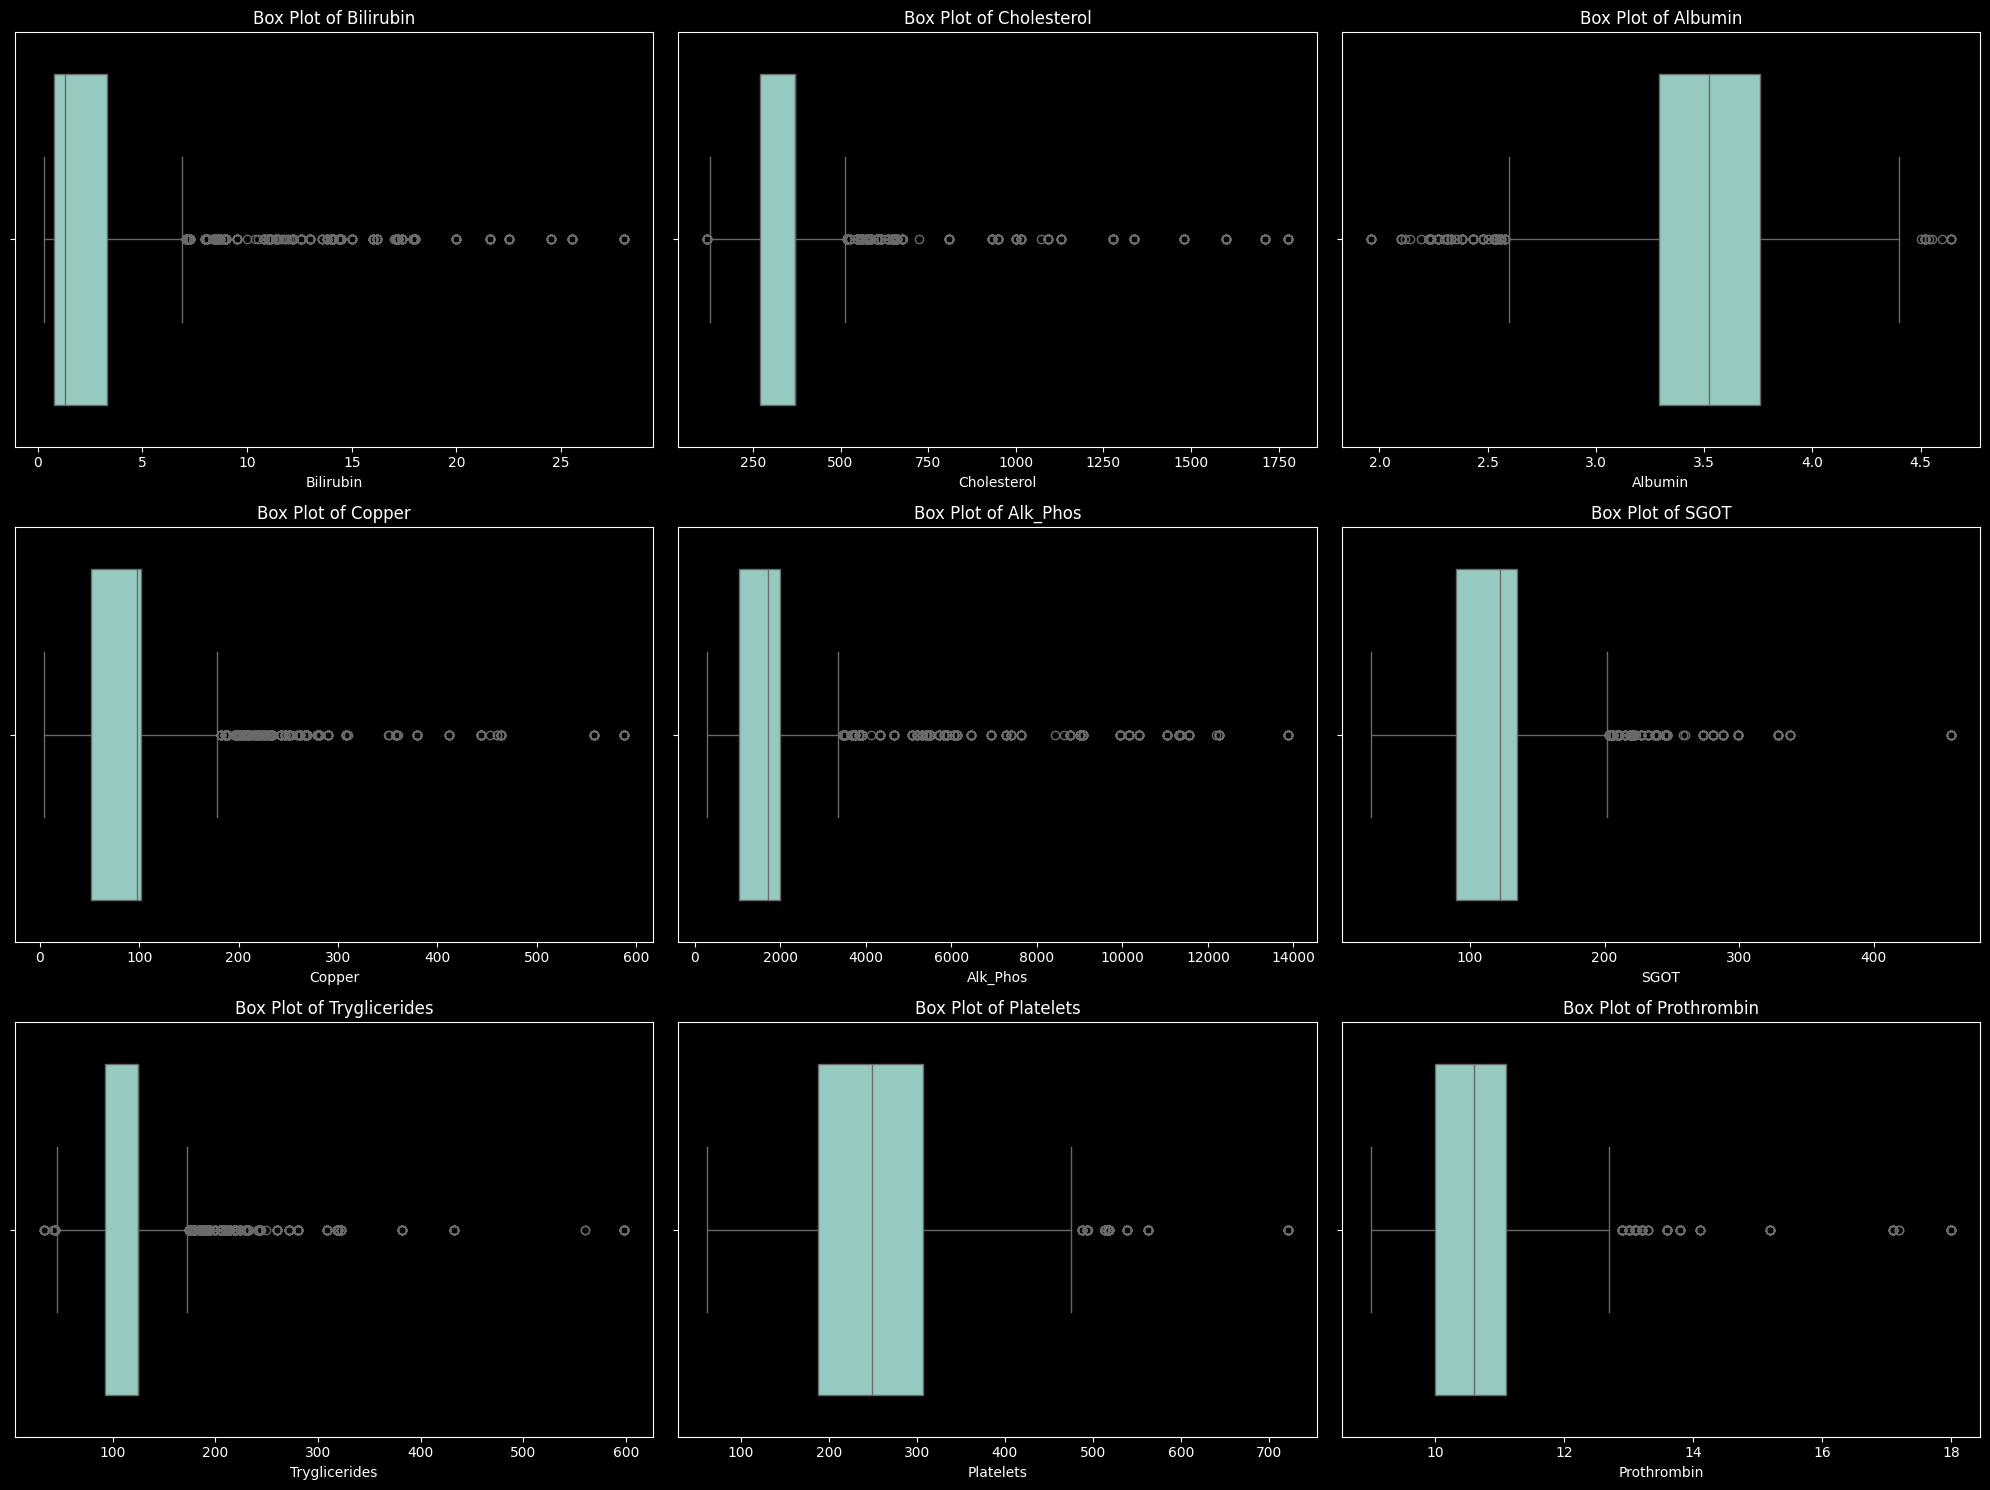

In [20]:
selected_cols = cont_cols.drop(['Stage', 'N_Days', 'Age'])

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
k = 0
for i in range(3):
    for j in range(3):
        if k < len(selected_cols):
            sns.boxplot(data=data, x=selected_cols[k], ax=axes[i, j])
            axes[i, j].set_title(f'Box Plot of {selected_cols[k]}')
            k += 1
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [21]:
def outlier(a):
    Q1 = a.quantile(0.25)
    Q3 = a.quantile(0.75)
    IQR = Q3-Q1
    L = Q1 - 1.5*IQR
    U = Q3 + 1.5*IQR
    return(L,U)
# ========================================
def cap(a):
    for i in a:
        data.loc[data[i] >= outlier(data[i])[1],i] = outlier(data[i])[1]
        data.loc[data[i] <= outlier(data[i])[0],i] = outlier(data[i])[0]
# ========================================
hh=cont_cols.drop(['Stage'])
cap(hh)
x = data.drop(['Stage'],axis=1)
y = data['Stage']

y = y - y.min() 

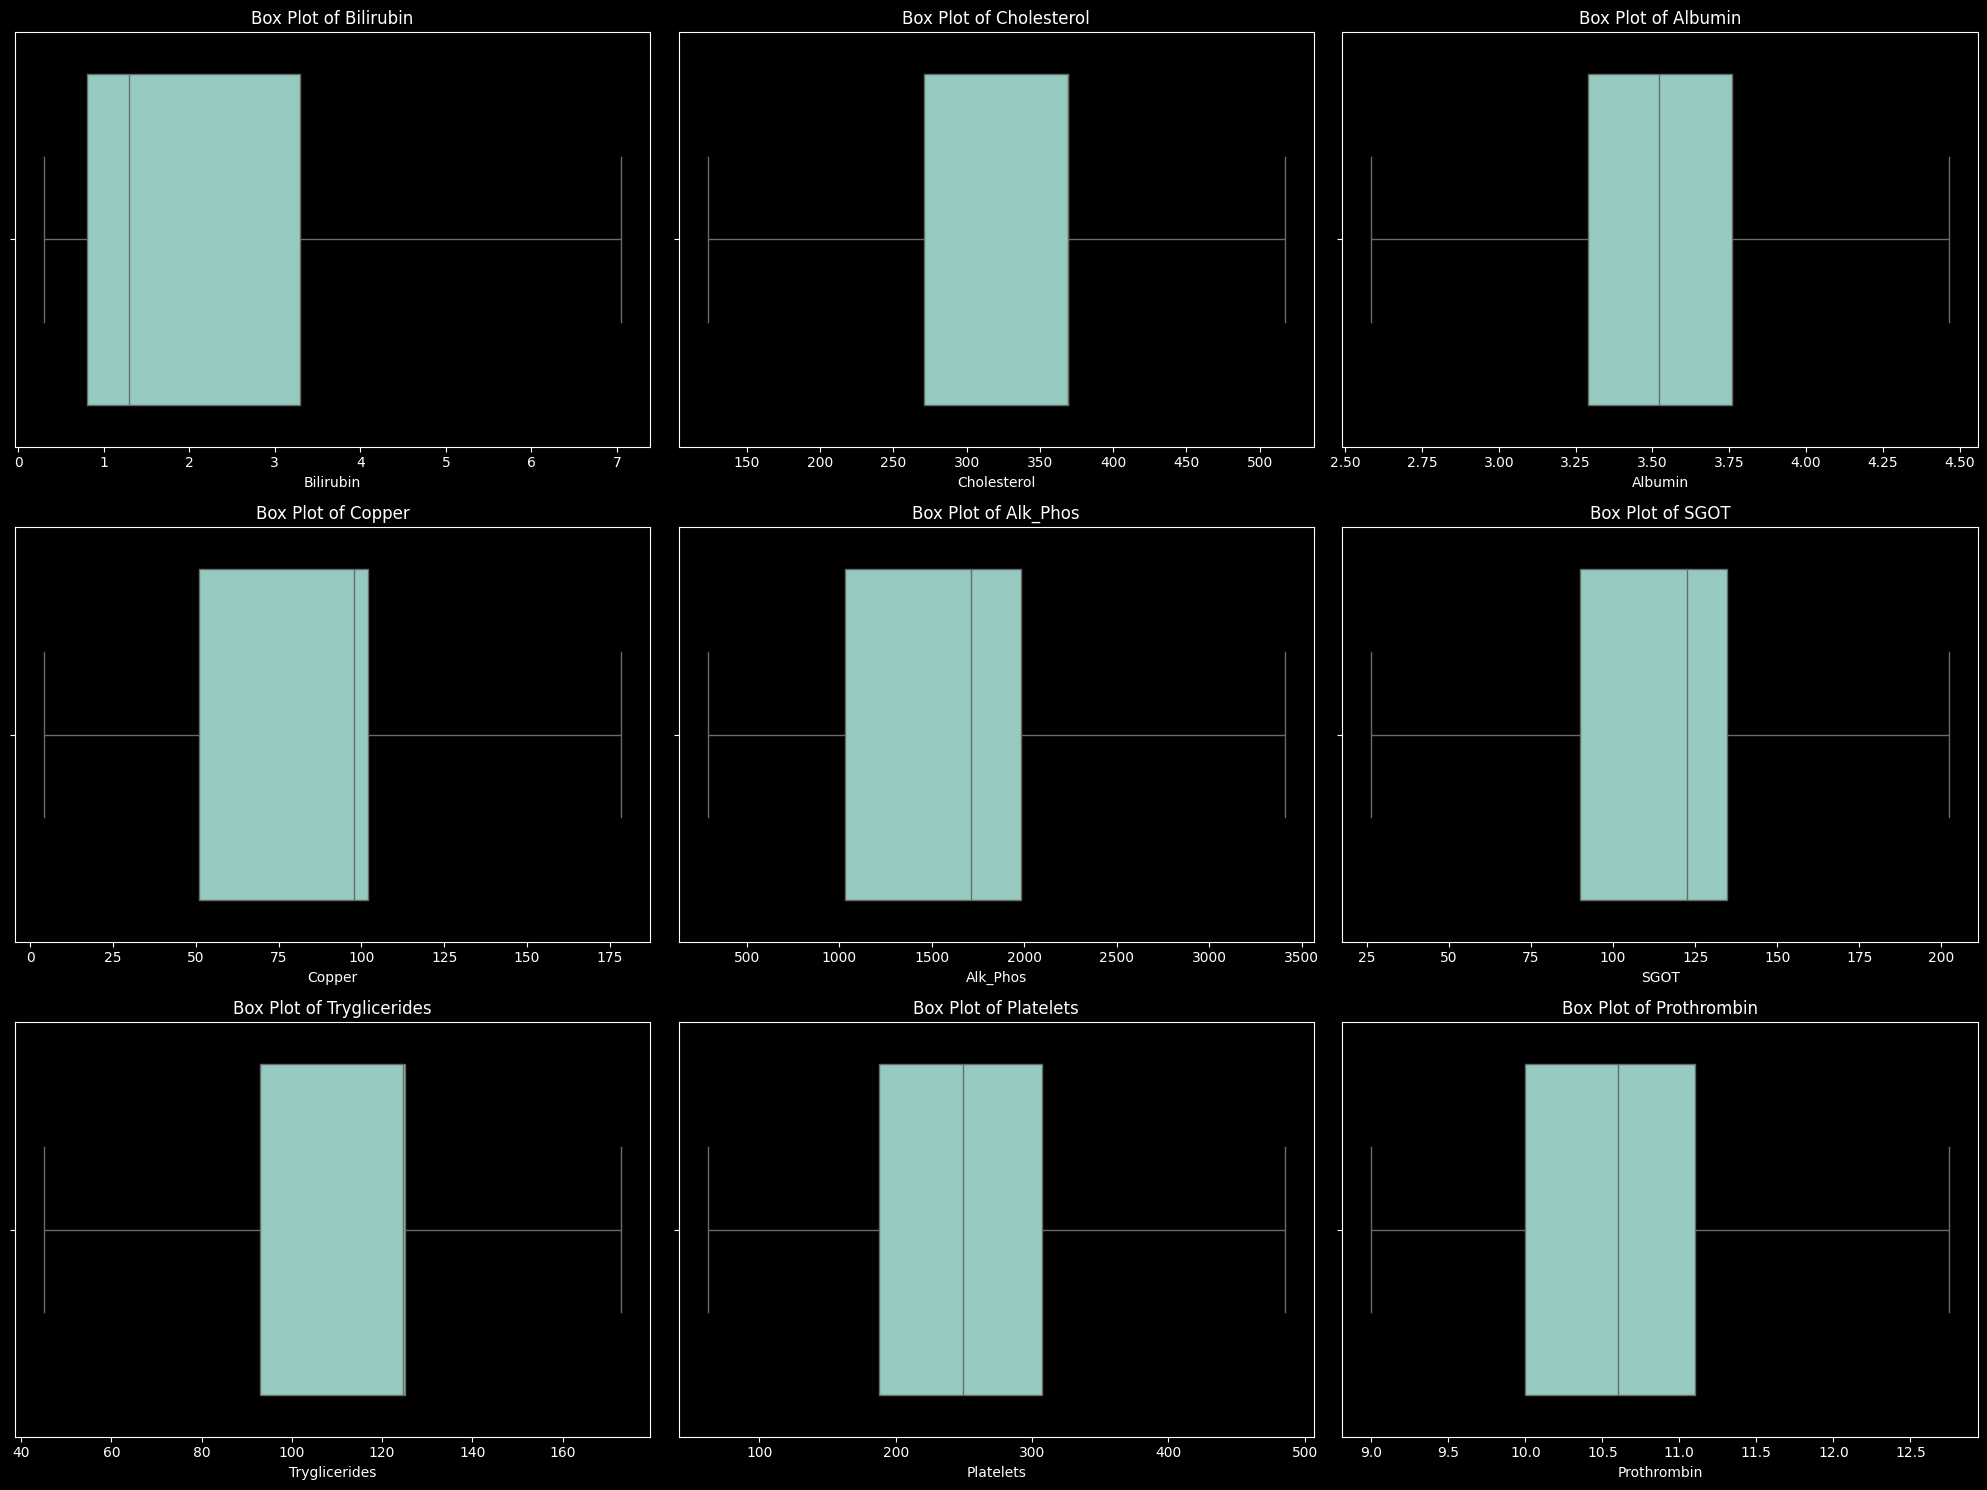

In [22]:
selected_cols = cont_cols.drop(['Stage', 'N_Days', 'Age'])

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
k = 0
for i in range(3):
    for j in range(3):
        if k < len(selected_cols):
            sns.boxplot(data=data, x=selected_cols[k], ax=axes[i, j])
            axes[i, j].set_title(f'Box Plot of {selected_cols[k]}')
            k += 1
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [23]:
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:, -1], random_state=3, train_size=.7)

yes_no_columns =['Ascites','Hepatomegaly','Spiders']
gender_column =['Sex']
onehot_columns =['Status','Edema']
binary=['Drug']

def binary_transform(X):
    return X.replace({'Y': 1, 'N': 0, 'F': 1, 'M': 0, 'Placebo':0,'D-penicillamine':1})

binary_transformer = FunctionTransformer(binary_transform)

cols_to_scale =['Albumin','Age','Bilirubin','Platelets','Prothrombin'] 

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, yes_no_columns + gender_column + binary),
        ('onehot', OneHotEncoder(handle_unknown='ignore', dtype=int), onehot_columns),
        ('scaler', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'  

)

Accuracy: 0.5577455048409405

Classification Report:
               precision    recall  f1-score   support

           1       0.53      0.62      0.57       953
           2       0.49      0.35      0.41       978
           3       0.63      0.70      0.67       961

    accuracy                           0.56      2892
   macro avg       0.55      0.56      0.55      2892
weighted avg       0.55      0.56      0.55      2892



C:\Users\Hany Mostafa\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


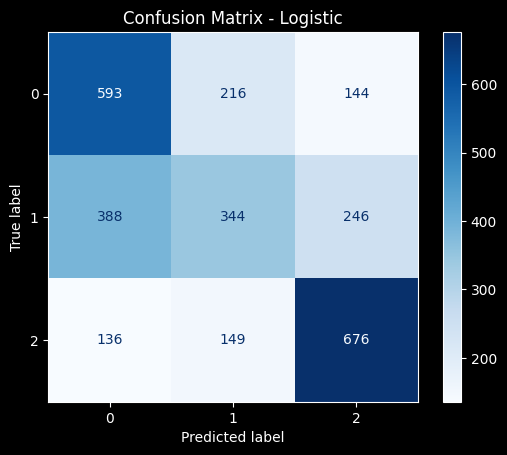

In [25]:
pipe_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LogisticRegression(class_weight='balanced',max_iter=100000))
])

pipe_logistic.fit(x_train, y_train)
y_pred_log = pipe_logistic.predict(x_test)


print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic")
plt.show()


Accuracy: 0.4581604426002766

Classification Report:
               precision    recall  f1-score   support

           1       0.46      0.54      0.50       953
           2       0.42      0.31      0.36       978
           3       0.48      0.53      0.50       961

    accuracy                           0.46      2892
   macro avg       0.45      0.46      0.45      2892
weighted avg       0.45      0.46      0.45      2892



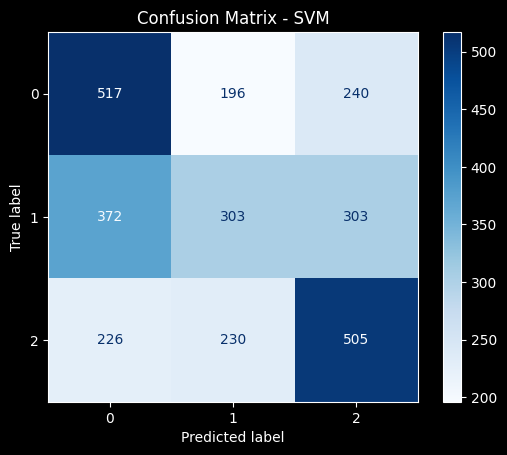

In [26]:

pipe_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(class_weight='balanced', probability=True))  
])

pipe_svm.fit(x_train, y_train)
y_pred_svm = pipe_svm.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.show()


Accuracy: 0.7475795297372061

Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.75      0.75       953
           2       0.71      0.70      0.70       978
           3       0.79      0.80      0.79       961

    accuracy                           0.75      2892
   macro avg       0.75      0.75      0.75      2892
weighted avg       0.75      0.75      0.75      2892



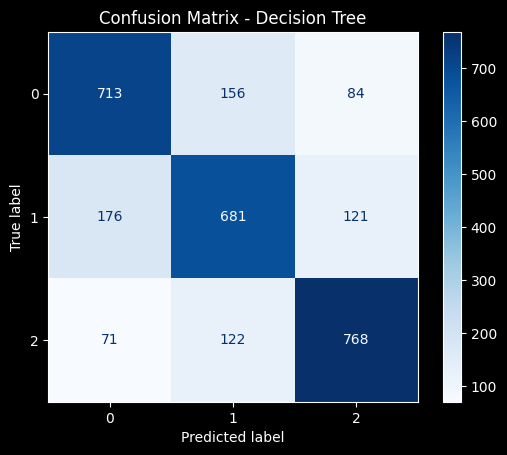

In [27]:
pipe_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

pipe_tree.fit(x_train, y_train)
y_pred_tree = pipe_tree.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))

cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()


Accuracy: 0.848893499308437

Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.82      0.84       953
           2       0.82      0.82      0.82       978
           3       0.87      0.91      0.89       961

    accuracy                           0.85      2892
   macro avg       0.85      0.85      0.85      2892
weighted avg       0.85      0.85      0.85      2892



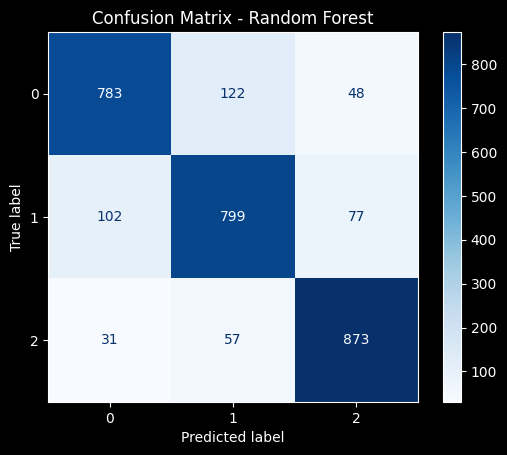

In [28]:
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100))
])

pipe_rf.fit(x_train, y_train)

y_pred_rf = pipe_rf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

e:\AI\Setup\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:35:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.87      0.88       953
           2       0.87      0.87      0.87       978
           3       0.91      0.93      0.92       961

    accuracy                           0.89      2892
   macro avg       0.89      0.89      0.89      2892
weighted avg       0.89      0.89      0.89      2892



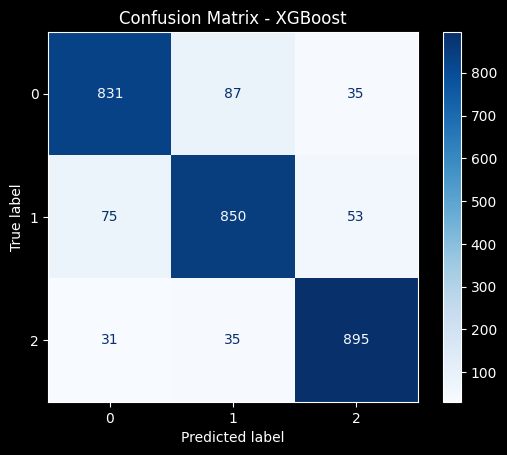

In [29]:
# Encode y once to start from 0 be 0 1 2 instead of 1 2 3 
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Pipeline for X (preprocessing + model)
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

# Train
pipe_xgb.fit(x_train, y_train_enc)

# Predict (encoded)
y_pred_enc = pipe_xgb.predict(x_test)

#decode y to be again stage 1 2 3 
y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test_enc)

print("Classification Report:")
print(classification_report(y_test_orig, y_pred))

cm = confusion_matrix(y_test_orig, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [30]:
print("Number of training samples:", x_train.shape[0])
print("Number of testing samples:", x_test.shape[0])

Number of training samples: 6747
Number of testing samples: 2892


# AUC

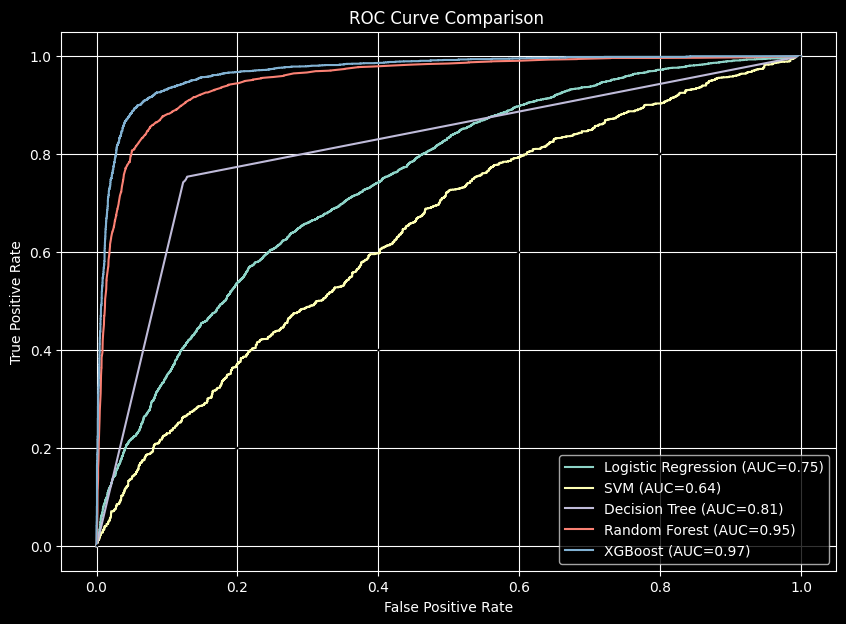

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

classes = np.unique(y_test)
n_classes = len(classes)

# Binarize y_test
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 7))

# Logistic Regression
y_score_lr = pipe_logistic.predict_proba(x_test)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score_lr.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC={roc_auc:.2f})")

# SVM
y_score_svm = pipe_svm.decision_function(x_test)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score_svm.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"SVM (AUC={roc_auc:.2f})")

# Decision Tree
y_score_dt = pipe_tree.predict_proba(x_test)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score_dt.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Decision Tree (AUC={roc_auc:.2f})")

# Random Forest
y_score_rf = pipe_rf.predict_proba(x_test)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score_rf.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc:.2f})")

# XGBoost
y_score_xgb = pipe_xgb.predict_proba(x_test)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score_xgb.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"XGBoost (AUC={roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison ")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [32]:
print("sklearn version:", sklearn.__version__)

sklearn version: 1.6.1


# Save the pipline 

In [33]:
joblib.dump({'pipeline': pipe_xgb, 'label_encoder': le}, "xgb_pipeline_with_le.pkl")


['xgb_pipeline_with_le.pkl']

In [34]:
import joblib

# === Load saved pipeline and LabelEncoder ===
# We saved them together in a dictionary, so we need to extract each
saved_objects = joblib.load("xgb_pipeline_with_le.pkl")

# Extract the pipeline (preprocessing + model)
pipe_xgb_loaded = saved_objects['pipeline']

# Extract the LabelEncoder for decoding target labels
le_loaded = saved_objects['label_encoder']

# === Make predictions using the loaded pipeline ===
# This returns encoded predictions (numbers)
y_pred_enc = pipe_xgb_loaded.predict(x_test)

# === Convert encoded predictions back to original labels ===
y_pred = le_loaded.inverse_transform(y_pred_enc)


# Test 

In [35]:
import pandas as pd
import joblib

saved = joblib.load("xgb_pipeline_with_le.pkl")
pipeline = saved["pipeline"]
le = saved["label_encoder"]

new_patient = pd.DataFrame([{
    "Age": 20075,
    "Sex": "M",
    "Ascites": "N",
    "Hepatomegaly": "Y",
    "Spiders": "N",
    "Drug": "Placebo",
    "Status": "C",
    "Edema": "N",
    "Albumin": 3.2,
    "Bilirubin": 1.8,
    "Platelets": 220,
    "Prothrombin": 10.5,
    "Cholesterol": 320,
    "Copper": 50,
    "Alk_Phos": 1200,
    "SGOT": 95,
    "Tryglicerides": 140,
    "N_Days": 0
}])

pred_enc = pipeline.predict(new_patient)
pred_label = le.inverse_transform(pred_enc)

print(f"🔮 Predicted Stage: {pred_label[0]}")


🔮 Predicted Stage: 2


In [36]:
saved = joblib.load("xgb_pipeline_with_le.pkl")
pipeline = saved["pipeline"]
le = saved["label_encoder"]

new_patient2 = pd.DataFrame([{
    "Age": 16060,
    "Sex": "F",
    "Ascites": "N",
    "Hepatomegaly": "N",
    "Spiders": "N",
    "Drug": "D-penicillamine",
    "Status": "CL",
    "Edema": "N",
    "Albumin": 4.0,
    "Bilirubin": 0.9,
    "Platelets": 280,
    "Prothrombin": 9.8,
    "Cholesterol": 250,
    "Copper": 60,
    "Alk_Phos": 980,
    "SGOT": 80,
    "Tryglicerides": 150,
    "N_Days": 0
}])

pred_enc = pipeline.predict(new_patient2)
pred_label = le.inverse_transform(pred_enc)

print(f"🔮 Predicted Stage: {pred_label[0]}")


🔮 Predicted Stage: 1


In [37]:
new_patient3 = pd.DataFrame([{
    "Age": 25550,
    "Sex": "M",
    "Ascites": "Y",
    "Hepatomegaly": "Y",
    "Spiders": "Y",
    "Drug": "Placebo",
    "Status": "D",
    "Edema": "Y",
    "Albumin": 2.6,
    "Bilirubin": 3.5,
    "Platelets": 120,
    "Prothrombin": 12.5,
    "Cholesterol": 400,
    "Copper": 90,
    "Alk_Phos": 1500,
    "SGOT": 130,
    "Tryglicerides": 180,
    "N_Days": 30
}])

pred_enc = pipeline.predict(new_patient3)
pred_label = le.inverse_transform(pred_enc)

print(f"🔮 Predicted Stage: {pred_label[0]}")


🔮 Predicted Stage: 3
